# Capstone Project: AI-Based Prediction of Road Accidents and Road Rage Using Traffic Data

**Overview**: This capstone project aims to use machine learning to predict the likelihood and severity of road accidents and identify risk factors for road rage in a specific state, such as California. By analyzing public traffic and crash data, the project will develop predictive models and conduct spatial and time-based analyses to pinpoint high-risk areas and conditions. The findings will be used to provide actionable recommendations for state agencies, helping them improve road safety through targeted interventions, better resource allocation, and focused campaigns against dangerous driving. Ultimately, the project will demonstrate how data science can help address major transportation safety challenges


### Getting Started

The analysis will utilize the US Accidents dataset from Kaggle [US Accidents (2016 - 2023)](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents), filtered by state (such as California, Texas, or another of interest) alongside accident data,[Registered Vehicles](https://data.transportation.gov/Roadways-and-Bridges/Motor-Vehicle-Registrations-1900-2023-MV-1-wide-fo/hwtm-7xmz/about_data) and [Registered Drivers](https://data.transportation.gov/d/xfkb-3bxx
) data is used. The accident dataset contains millions of accident records across the US, but the analysis will be limited to one chosen state for computational feasibility and model relevance. 


**Note:** This notebook is next phase after Exploratory Data Analysis (EDA), refere to [anaysis.ipynb](https://github.com/hemant280/berkely-ai-ml-capstone/blob/main/analysis.ipynb) for data analysis steps and how features are generated, the [final_accidents_vehicles_drivers_OR](https://github.com/hemant280/berkeley-ai-ml-capstone/blob/main/data/final_accidents_vehicles_drivers_OR.csv) is generated by analysis notebook.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer, StandardScaler

ANALYSIS_STATE_NAME = "Oregon"
ANALYSIS_STATE_CODE = "OR"

In [5]:
# Read the dataset file final_accidents_vehicles_drivers_df generated by EDA analysis notebook
eda_df = pd.read_csv(f'data/final_accidents_vehicles_drivers_{ANALYSIS_STATE_CODE}.csv')

In [6]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179660 entries, 0 to 179659
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Severity                   179660 non-null  int64  
 1   Temperature(F)             179660 non-null  float64
 2   Humidity(%)                179660 non-null  float64
 3   Pressure(in)               179660 non-null  float64
 4   Visibility(mi)             179660 non-null  float64
 5   Wind_Speed(mph)            179660 non-null  float64
 6   Amenity                    179660 non-null  int64  
 7   Bump                       179660 non-null  int64  
 8   Crossing                   179660 non-null  int64  
 9   Give_Way                   179660 non-null  int64  
 10  Junction                   179660 non-null  int64  
 11  No_Exit                    179660 non-null  int64  
 12  Railway                    179660 non-null  int64  
 13  Roundabout                 17

In [7]:
# Convert the Start_Time_TS datetime format and extract useful features
eda_df['Start_Time_TS'] = pd.to_datetime(eda_df['Start_Time_TS'], errors='coerce')
eda_df["Start_Month"] = eda_df["Start_Time_TS"].dt.month
eda_df["Start_Day"] = eda_df["Start_Time_TS"].dt.day
eda_df["Start_Weekday"] = eda_df["Start_Time_TS"].dt.weekday  # Monday=0, Sunday=6
eda_df["Start_Hour"] = eda_df["Start_Time_TS"].dt.hour
eda_df["Start_Minute"] = eda_df["Start_Time_TS"].dt.minute
eda_df["Start_Is_Weekend"] = (eda_df["Start_Time_TS"].dt.weekday >= 5).astype(int)
# Dropping the original Start_Time_TS column
eda_df = eda_df.drop(columns=['Start_Time_TS'])
# Dropping End_Time_TS column as we have Start_Time_TS and Duration
eda_df = eda_df.drop(columns=['End_Time_TS'])

In [8]:

feature_df = eda_df.drop(["Severity"], axis=1)
target_df = pd.DataFrame(eda_df["Severity"], columns=["Severity"])
target_df = target_df.reset_index(drop=True)
feature_df.info()
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179660 entries, 0 to 179659
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Temperature(F)             179660 non-null  float64
 1   Humidity(%)                179660 non-null  float64
 2   Pressure(in)               179660 non-null  float64
 3   Visibility(mi)             179660 non-null  float64
 4   Wind_Speed(mph)            179660 non-null  float64
 5   Amenity                    179660 non-null  int64  
 6   Bump                       179660 non-null  int64  
 7   Crossing                   179660 non-null  int64  
 8   Give_Way                   179660 non-null  int64  
 9   Junction                   179660 non-null  int64  
 10  No_Exit                    179660 non-null  int64  
 11  Railway                    179660 non-null  int64  
 12  Roundabout                 179660 non-null  int64  
 13  Station                    17

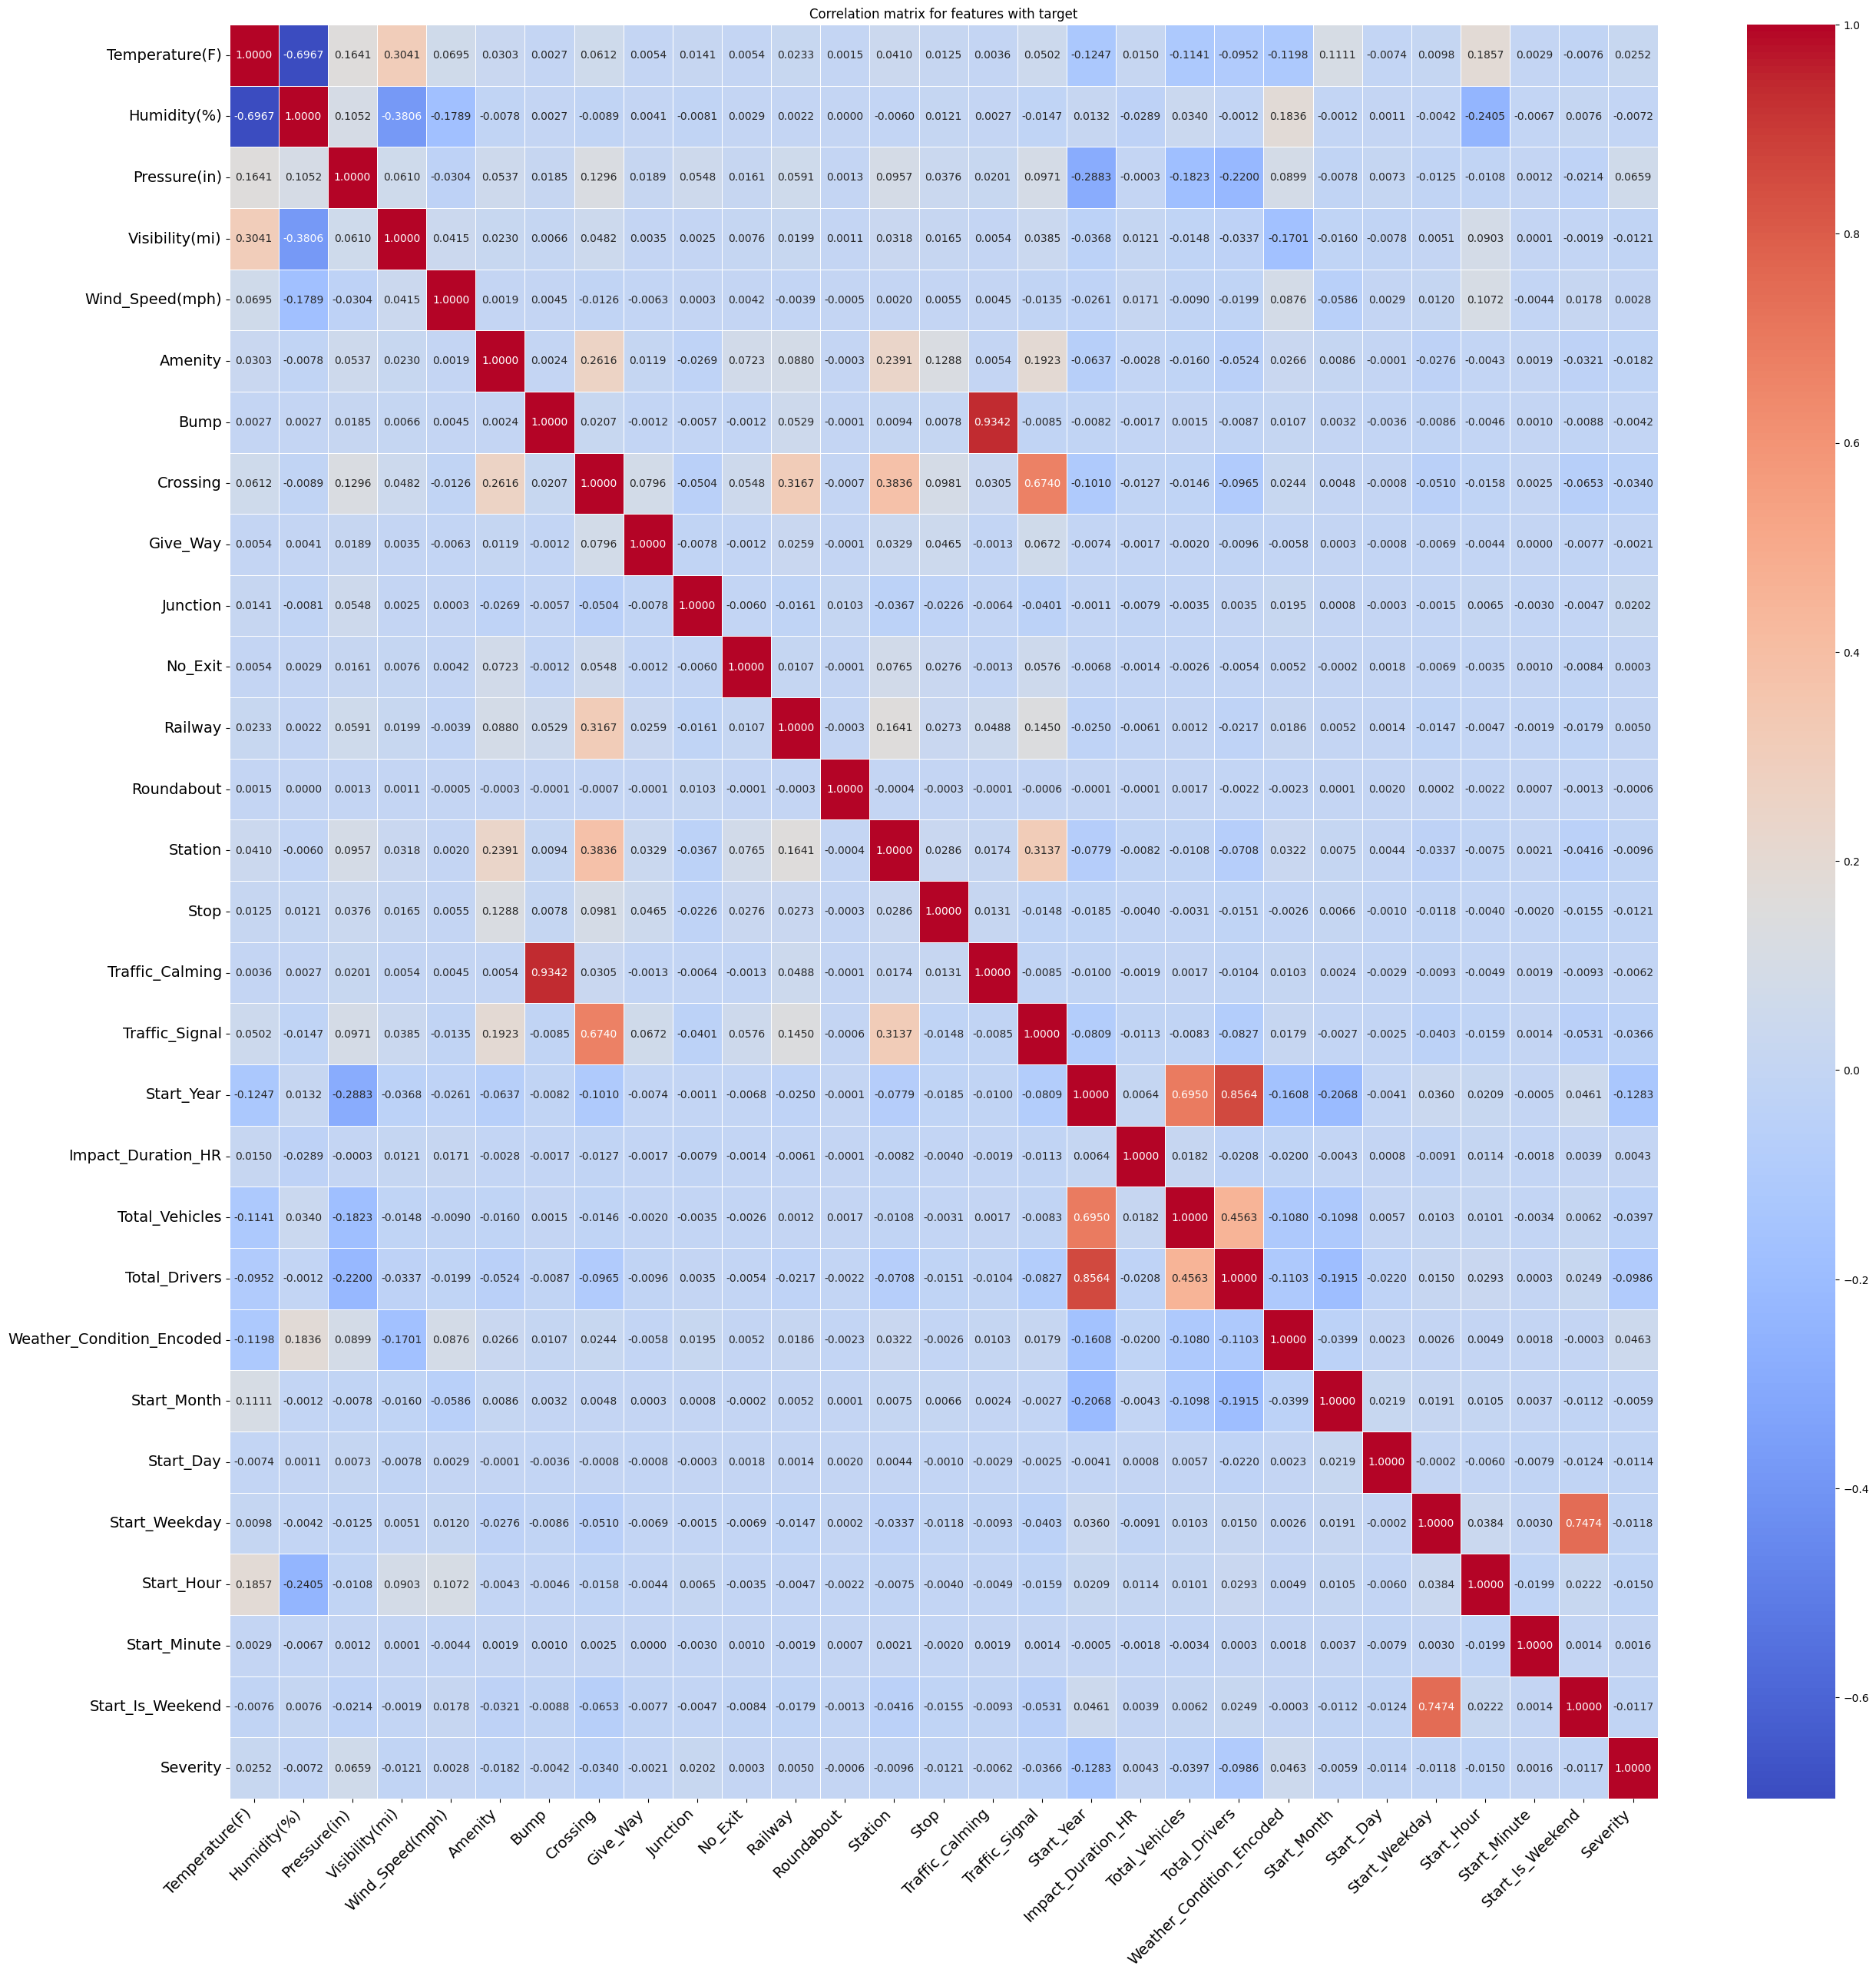

In [9]:
correlation_mat = pd.concat([feature_df, target_df], axis=1).corr()
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(correlation_mat, cmap="coolwarm", fmt=".4f", linewidths=0.5, annot=True)
# Get and set the font size for the axis tick labels
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=14, ha="right")

plt.title("Correlation matrix for features with target")
plt.show()

In [10]:
# Indentify highly correlated features
threshold = 0.8
high_corr_pairs = []
for i in range(len(correlation_mat.columns)):
    for j in range(i):
        if abs(correlation_mat.iloc[i, j]) > threshold and correlation_mat.columns[i] != correlation_mat.columns[j]:
            high_corr_pairs.append((correlation_mat.columns[i], correlation_mat.columns[j], correlation_mat.iloc[i, j]))
high_corr_pairs

[('Traffic_Calming', 'Bump', 0.9342376650703605),
 ('Total_Drivers', 'Start_Year', 0.8563697312016818)]

Removing highly correlated features
- Remove 
    - Start_Year 
    - Traffic_Calming


In [11]:
# Remove highly correlated features
# - Keep Start_Time_TS as it is highly correlated with End_Time_TS and also it is more relevant for modeling
feature_df = feature_df.drop(columns=["Start_Year", "Traffic_Calming"], errors="ignore")

In [12]:
feature_df.describe()

,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Amenity,Bump,Crossing,Give_Way,Junction,...,Impact_Duration_HR,Total_Vehicles,Total_Drivers,Weather_Condition_Encoded,Start_Month,Start_Day,Start_Weekday,Start_Hour,Start_Minute,Start_Is_Weekend
count,179660.000000,179660.000000,179660.000000,179660.000000,179660.000000,179660.000000,179660.000000,179660.000000,179660.000000,179660.000000,...,179660.000000,1.796600e+05,1.796600e+05,179660.000000,179660.000000,179660.000000,179660.000000,179660.000000,179660.000000,179660.000000
mean,51.188920,69.691857,29.222033,8.713026,7.132643,0.014962,0.001186,0.075877,0.001163,0.050173,...,15.092531,4.028313e+06,3.006098e+06,21.199777,6.793799,15.781933,2.837710,12.466147,29.735595,0.228849
std,16.624588,21.961386,1.346967,2.777182,5.560848,0.121399,0.034412,0.264801,0.034088,0.218301,...,262.324860,9.194184e+04,6.549065e+04,17.771327,3.864198,8.637608,1.925607,5.789246,17.229759,0.420093
min,-35.000000,4.000000,24.390000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.020000,3.811706e+06,2.855746e+06,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,55.000000,29.120000,10.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.160000,3.942875e+06,2.944828e+06,8.000000,3.000000,9.000000,1.000000,8.000000,15.000000,0.000000
50%,49.000000,75.000000,29.830000,10.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.200000,4.010635e+06,3.002014e+06,8.000000,7.000000,16.000000,3.000000,13.000000,30.000000,0.000000
75%,61.000000,88.000000,30.040000,10.000000,9.200000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,4.095442e+06,3.029912e+06,40.000000,10.000000,23.000000,4.000000,17.000000,45.000000,0.000000
max,117.000000,100.000000,31.020000,43.000000,122.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,15594.120000,4.230276e+06,3.146632e+06,66.000000,12.000000,31.000000,6.000000,23.000000,59.000000,1.000000


In [13]:
# final check to ensure no missing values
print("Missing values in target_df:", feature_df.isnull().sum().sum())
print("Missing values in target_df:", target_df.isnull().sum().sum())
print("Shape for feature_df:", feature_df.shape)
print("Shape for target_df:", target_df.shape)

Missing values in target_df: 0
Missing values in target_df: 0
Shape for feature_df: (179660, 26)
Shape for target_df: (179660, 1)


### PCA Analysis
We want to reduce the dimensionality, we will use Principal Component Analysis to get the principal components and reduce the dimensionality

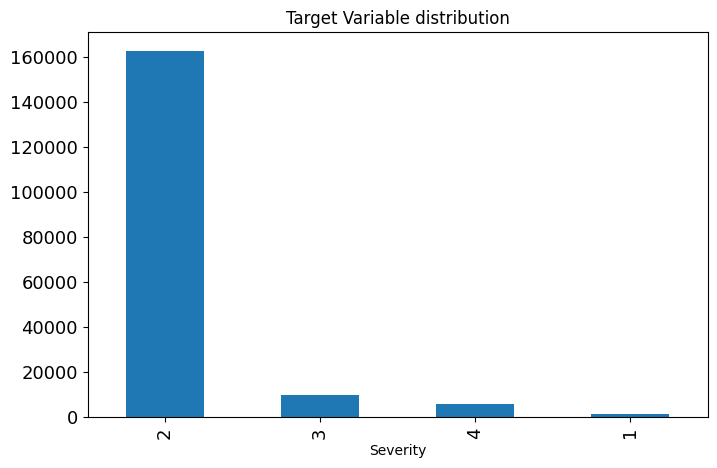

In [14]:
# Plotting the target variable distribution
target_df["Severity"].value_counts().plot(
    kind="bar", figsize=(8, 5), fontsize=13, title="Target Variable distribution"
)
plt.savefig(f"./images/target_variable_distribution_{ANALYSIS_STATE_CODE}.png")

Split the dataset for training and testing
Using SMOTE to address the imbalance in target (Severity) column

In [15]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
x_train, x_test, y_train, y_test = train_test_split(
    feature_df, target_df, test_size=0.2, random_state=101
)
sm = SMOTE(random_state=42)

print("Shape of: (Training Dataset before and after SMOTE)")
print(f"- x_train before: {x_train.shape}")
print(f"- y_train before: {y_train.shape}")

x_train, y_train = sm.fit_resample(x_train, y_train)

print(f"- x_train after: {x_train.shape}")
print(f"- y_train after: {y_train.shape}")
print(
    "\nBalance of positive and negative classes (%):",
    y_train.value_counts(normalize=True) * 100,
)


Shape of: (Training Dataset before and after SMOTE)
- x_train before: (143728, 26)
- y_train before: (143728, 1)
- x_train after: (520876, 26)
- y_train after: (520876, 1)

Balance of positive and negative classes (%): Severity
1           25.0
2           25.0
3           25.0
4           25.0
Name: proportion, dtype: float64


In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def perform_pca_analysis(x_train, x_test, n_components=None):
    """
    Perform PCA analysis on the training and testing data.
    Standardize the data, perform PCA, and return the transformed data along with the PCA object.
    """
    # Helper function to find the top features that contribute most to each principal component
    def get_top_features(loadings_df, n_features=5):
        top_features = {}
        for component in loadings_df.columns:
            sorted_features = loadings_df[component].abs().sort_values(ascending=False)
            top_features[component] = sorted_features.index[:n_features].tolist()
        return top_features

    # Standardize the data
    # standardize features before PCA, as it is sensitive to the scale of the data.
    random_seed = 42
    np.random.seed(random_seed)
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.fit_transform(x_test)

    if not n_components:
        # Calculate the number of components to explain 95% variance
        # Perform PCA
        pca = PCA()
        pca.fit(x_train_scaled)
        # Calculate cumulative explained variance
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        # Find the number of components for 95% variance
        n_components = np.where(cumulative_variance >= 0.95)[0][0] + 1
        print(f"Number of components to capture 95% variance: {n_components}")
    pca = PCA(n_components=n_components)
    x_train_pca = pca.fit_transform(x_train_scaled)
    x_test_pca = pca.fit_transform(x_test_scaled)
    # Create a new DataFrame with the principal components
    column_names = [f"PC{i+1}" for i in range(x_train_pca.shape[1])]
    x_train_pca_df = pd.DataFrame(data=x_train_pca, columns=column_names)
    x_test_pca_df = pd.DataFrame(data=x_test_pca, columns=column_names)

    # Create a DataFrame for the loadings
    # The pca.components_ attribute needs to be transposed for clarity
    loadings_df = pd.DataFrame(
        pca.components_.T,
        columns=[f"PC{i+1}" for i in range(pca.n_components_)],
        index=x_train.columns,
    )

    top_contributions = get_top_features(loadings_df)
    print("\nTop contributing features for each principal component:")
    for component, features in top_contributions.items():
        print(f"{component}: {features}")
    return x_train_pca_df, x_test_pca_df, pca

In [17]:
x_train_pca, x_test_pca, pca = perform_pca_analysis(x_train, x_test)

Number of components to capture 95% variance: 23

Top contributing features for each principal component:
PC1: ['Crossing', 'Traffic_Signal', 'Station', 'Amenity', 'Railway']
PC2: ['Humidity(%)', 'Temperature(F)', 'Visibility(mi)', 'Start_Hour', 'Weather_Condition_Encoded']
PC3: ['Start_Weekday', 'Start_Is_Weekend', 'Total_Drivers', 'Crossing', 'Humidity(%)']
PC4: ['Total_Vehicles', 'Total_Drivers', 'Pressure(in)', 'Start_Month', 'Weather_Condition_Encoded']
PC5: ['Wind_Speed(mph)', 'Weather_Condition_Encoded', 'Start_Month', 'Start_Hour', 'Visibility(mi)']
PC6: ['Stop', 'Amenity', 'Junction', 'Railway', 'Traffic_Signal']
PC7: ['Bump', 'Pressure(in)', 'Junction', 'Stop', 'Start_Month']
PC8: ['Bump', 'Junction', 'Railway', 'Start_Minute', 'Give_Way']
PC9: ['Start_Minute', 'Start_Day', 'Impact_Duration_HR', 'Start_Month', 'Give_Way']
PC10: ['Give_Way', 'No_Exit', 'Junction', 'Impact_Duration_HR', 'Start_Day']
PC11: ['Impact_Duration_HR', 'No_Exit', 'Give_Way', 'Start_Month', 'Pressure(in

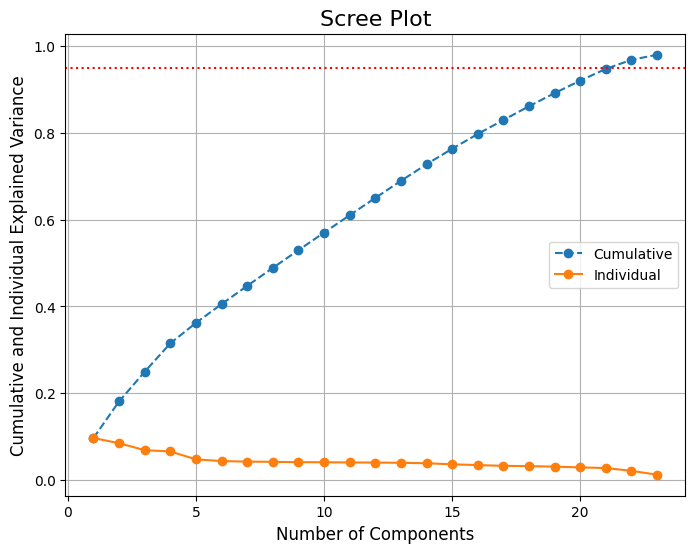

In [18]:
# Create the Scree Plot
plt.figure(figsize=(8, 6))
# Calculate the cumulative sum of the explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker="o",
    linestyle="--",
)
plt.plot(
    range(1, len(cumulative_variance) + 1),
    pca.explained_variance_ratio_,
    marker="o",
    linestyle="-",
)

plt.title("Scree Plot", fontsize=16)
plt.xlabel("Number of Components", fontsize=12)
plt.ylabel("Cumulative and Individual Explained Variance", fontsize=12)
plt.legend(["Cumulative", "Individual"], loc="best")
plt.grid(True)
plt.axhline(y=0.95, color="r", linestyle=":", label="95% Explained Variance")
plt.savefig(f"./images/pca_component_ratio_{ANALYSIS_STATE_CODE}.png")
plt.show()

We will limit the PCA to 5 components

In [19]:
x_train_pca, x_test_pca, pca = perform_pca_analysis(x_train, x_test,n_components=5)


Top contributing features for each principal component:
PC1: ['Crossing', 'Traffic_Signal', 'Station', 'Amenity', 'Railway']
PC2: ['Humidity(%)', 'Temperature(F)', 'Visibility(mi)', 'Start_Hour', 'Weather_Condition_Encoded']
PC3: ['Start_Weekday', 'Start_Is_Weekend', 'Total_Drivers', 'Crossing', 'Humidity(%)']
PC4: ['Total_Vehicles', 'Total_Drivers', 'Pressure(in)', 'Start_Month', 'Weather_Condition_Encoded']
PC5: ['Wind_Speed(mph)', 'Weather_Condition_Encoded', 'Start_Month', 'Start_Hour', 'Visibility(mi)']


#### Implement a Random Forest classifier


In [20]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler

# Define the Random Forest model with class weighting
classifier = RandomForestClassifier(class_weight="balanced", random_state=42)

# Create the pipeline with SMOTE
pipeline = ImbPipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("classifier", classifier),
    ]
)

# Define the hyperparameter search space
param_dist = {
    "classifier__n_estimators": randint(10, 50),
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_split": randint(2, 20),
    "classifier__min_samples_leaf": randint(1, 20),
    "classifier__bootstrap": [True],
}

# Define the stratified cross-validation strategy
stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Run the Randomized Search using the sampled data
rf_random = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=15,  # Reduced iterations for faster tuning
    cv=stratified_cv,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

# Fit the search on the smaller, representative sample
rf_random.fit(x_train_pca, y_train.to_numpy().ravel())

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END classifier__bootstrap=True, classifier__max_features=sqrt, classifier__min_samples_leaf=15, classifier__min_samples_split=12, classifier__n_estimators=17; total time=  21.0s
[CV] END classifier__bootstrap=True, classifier__max_features=sqrt, classifier__min_samples_leaf=15, classifier__min_samples_split=12, classifier__n_estimators=17; total time=  21.5s
[CV] END classifier__bootstrap=True, classifier__max_features=sqrt, classifier__min_samples_leaf=15, classifier__min_samples_split=12, classifier__n_estimators=17; total time=  22.7s
[CV] END classifier__bootstrap=True, classifier__max_features=sqrt, classifier__min_samples_leaf=7, classifier__min_samples_split=12, classifier__n_estimators=20; total time=  25.6s
[CV] END classifier__bootstrap=True, classifier__max_features=sqrt, classifier__min_samples_leaf=7, classifier__min_samples_split=12, classifier__n_estimators=20; total time=  25.9s
[CV] END classifier__boots

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('smote', SMOTE(random_state=42)),
                                             ('classifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'classifier__bootstrap': [True],
                                        'classifier__max_features': ['sqrt',
                                                                     'log2'],
                                        'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17426b490>,
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1742474d0>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x174247710>},
                   random_state=42, verbose=2)

In [21]:
# Get the best parameters found by the search
best_params = rf_random.best_params_

# Strip the "classifier__" prefix from the keys
stripped_params = {
    key.replace("classifier__", ""): value for key, value in best_params.items()
}
# Create a new pipeline with the best parameters
final_pipeline = ImbPipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        (
            "classifier",
            RandomForestClassifier(
                class_weight="balanced", random_state=42, **stripped_params
            ),
        ),
    ]
)

# Train the final model on the entire dataset
final_pipeline.fit(x_train_pca, y_train.to_numpy().ravel())

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features='log2', min_samples_leaf=2,
                                        n_estimators=21, random_state=42))])

### Evaluate the Model


In [22]:
# x_test_pca and y_test are test sets
# Get the best estimator from the Randomized Search
from sklearn.metrics import classification_report

final_model = final_pipeline.get_params()['classifier']

# Make predictions on the unseen test data
y_pred = final_model.predict(x_test_pca.values)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.01      0.02      0.01       282
           2       0.90      0.74      0.81     32494
           3       0.04      0.13      0.07      1953
           4       0.04      0.10      0.06      1203

    accuracy                           0.68     35932
   macro avg       0.25      0.25      0.24     35932
weighted avg       0.82      0.68      0.74     35932



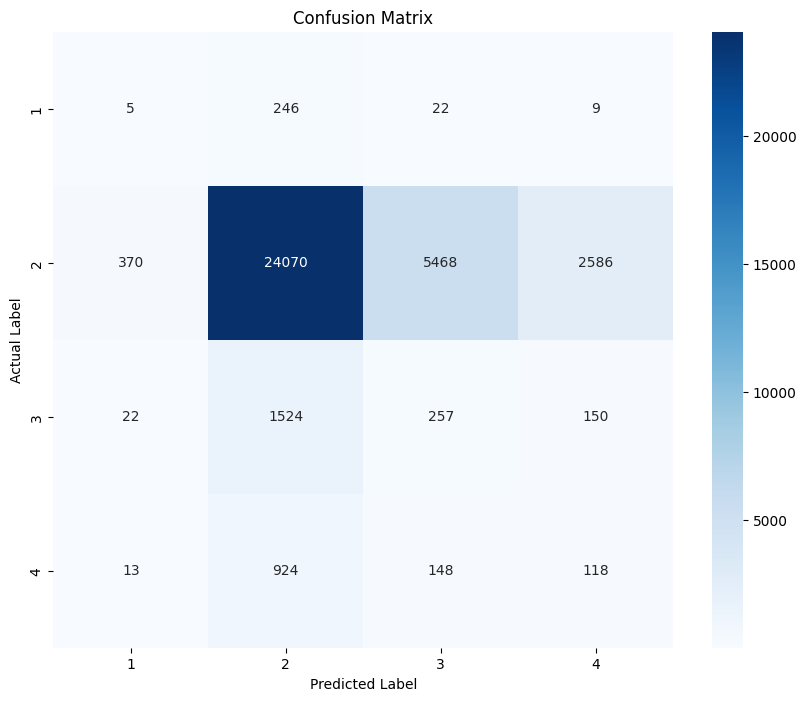

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=final_model.classes_,
    yticklabels=final_model.classes_,
)
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

In [24]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

# Create a baseline model that always predicts the most frequent class
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(x_train_pca, y_train.to_numpy().ravel())
dummy_pred = dummy_clf.predict(x_test_pca)

print("Baseline Model Performance:")
print(classification_report(y_test, dummy_pred, zero_division=0))

Baseline Model Performance:
              precision    recall  f1-score   support

           1       0.01      1.00      0.02       282
           2       0.00      0.00      0.00     32494
           3       0.00      0.00      0.00      1953
           4       0.00      0.00      0.00      1203

    accuracy                           0.01     35932
   macro avg       0.00      0.25      0.00     35932
weighted avg       0.00      0.01      0.00     35932



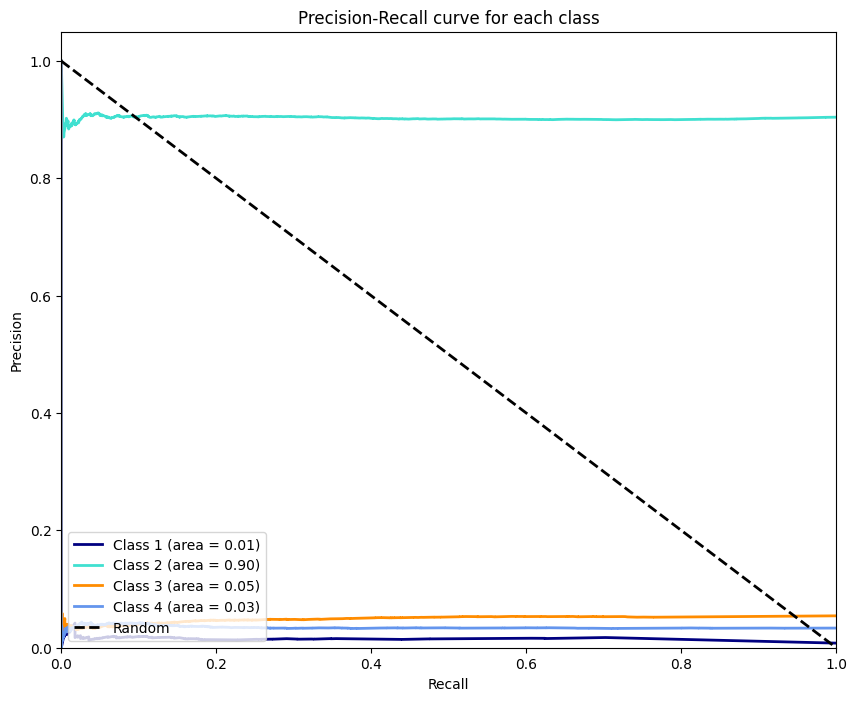

In [25]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the output for multi-class PR curve
y_test_bin = label_binarize(y_test, classes=final_model.classes_)
y_score = final_model.predict_proba(x_test_pca.values)

# Plot for each class
plt.figure(figsize=(10, 8))
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])
for i, color in zip(range(len(final_model.classes_)), colors):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(
        recall,
        precision,
        color=color,
        lw=2,
        label=f"Class {final_model.classes_[i]} (area = {pr_auc:0.2f})",
    )

plt.plot([0, 1], [1, 0], "k--", lw=2, label="Random")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve for each class")
plt.legend(loc="lower left")
plt.show()

User Seares of Classifier

In [26]:
import time

# Import classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [27]:
classifiers = {
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(
        solver="liblinear", random_state=42
    ),  # Specify solver
    "Decision Tree": DecisionTreeClassifier(random_state=42),
}

results = {}

for name, classifier in classifiers.items():
    print(f"Training and evaluating {name}...")
    # Train the classifier on PCA-transformed training data
    # Use .ravel() to convert y_train to a 1D array, y_train is a DataFrame, convert to numpy array first
    classifier.fit(x_train_pca, y_train.to_numpy().ravel())
    train_time = None
    start_time = time.time()
    classifier.fit(x_train_pca, y_train.to_numpy().ravel())
    train_time = time.time() - start_time

    # Make predictions on PCA-transformed test data
    y_pred = classifier.predict(x_test_pca)

    # Evaluate the classifier
    train_accuracy = accuracy_score(
        y_train.to_numpy().ravel(), classifier.predict(x_train_pca)
    )
    test_accuracy = accuracy_score(y_test, y_pred)

    results[name] = {
        "name": name,
        "train_time": train_time,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
    }

Training and evaluating K-Nearest Neighbors...
Training and evaluating Logistic Regression...
Training and evaluating Decision Tree...


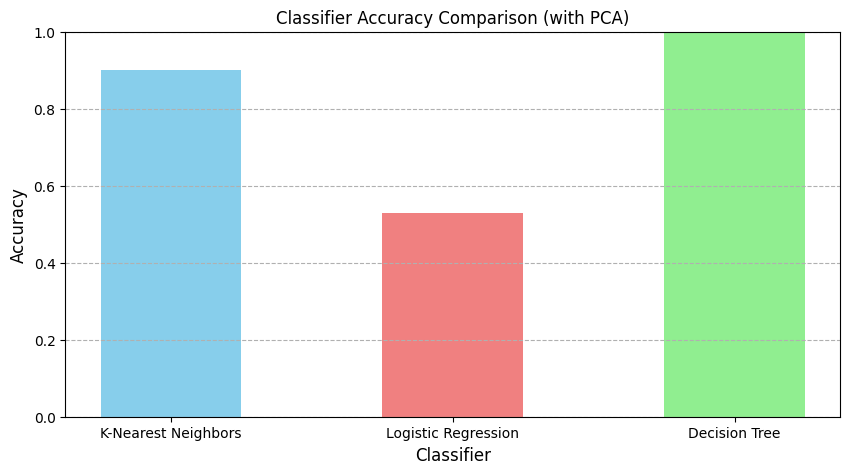


Summary of Classifier Performance:
| Model | Train Time (s) | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
| K-Nearest Neighbors | 0.2198 | 0.8998 | 0.5302 |
| Logistic Regression | 0.9878 | 0.5288 | 0.3016 |
| Decision Tree | 5.1920 | 0.9989 | 0.5366 |
<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, K-Nearest Neighbors to Decision Tree
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            3 non-null      object
 1   train_time      3 non-null      object
 2   train_accuracy  3 non-null      object
 3   test_accuracy   3 non-null      object
dtypes: object(4)
memory usage: 120.0+ bytes


In [28]:
accuracy_scores = {name: res["train_accuracy"] for name, res in results.items()}
summary_df = pd.DataFrame(results).T
# Create a bar plot of accuracy scores
fig, ax = plt.subplots(figsize=(10, 5), squeeze=True)
plt.bar(
    accuracy_scores.keys(),
    accuracy_scores.values(),
    color=["skyblue", "lightcoral", "lightgreen", "gold"],
    width=0.5,
)
plt.xlabel("Classifier", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12, ha='right')
plt.title("Classifier Accuracy Comparison (with PCA)", fontsize=12)
plt.ylim(0, 1)  # Ensure y-axis starts at 0
plt.grid(axis="y", linestyle="--")
plt.savefig(f"./images/classifier_accuracy_comparision_{ANALYSIS_STATE_CODE}.png", bbox_inches="tight")
plt.show()


# Generate a summary table
print("\nSummary of Classifier Performance:")
print("| Model | Train Time (s) | Train Accuracy | Test Accuracy |")
print("| ----- | ---------- | -------------  | -----------   |")
for name, metrics in results.items():
    print(
        f"| {name} | {metrics['train_time']:.4f} | {metrics['train_accuracy']:.4f} | {metrics['test_accuracy']:.4f} |"
    )
summary_df.info()

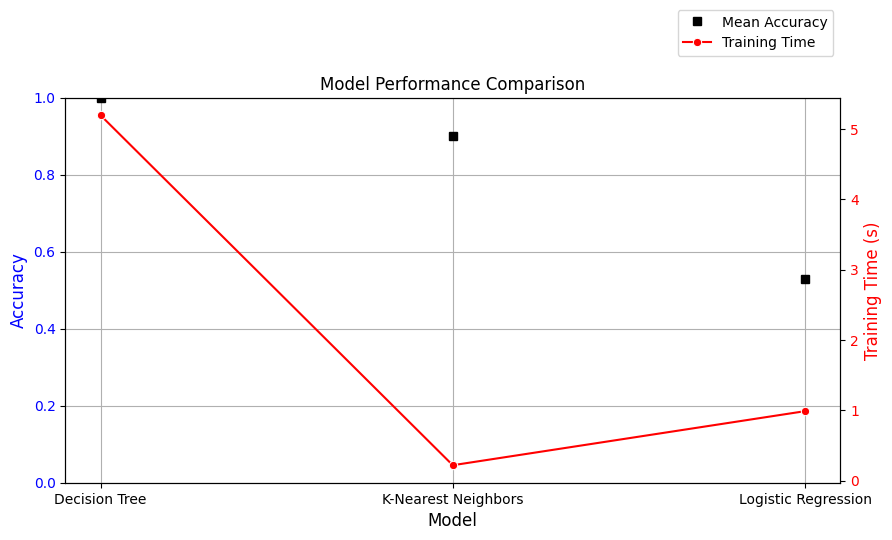

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5), squeeze=True)

ax1.set_xlabel("Model", fontsize=12)
ax1.set_ylabel("Accuracy", color="blue", fontsize=12)
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_ylim(0, 1)  # Set y-axis limit for accuracy
ax1.grid(axis="both")


# Add markers for the mean accuracy on the boxplot
mean_accuracies = summary_df.groupby("name")["train_accuracy"].mean()
ax1.plot(
    mean_accuracies.index,
    mean_accuracies.values,
    "s",
    color="black",
    label="Mean Accuracy",
)

# Create a secondary axis for training time
ax2 = ax1.twinx()
sns.lineplot(
    x="name",
    y="train_time",
    data=summary_df,
    ax=ax2,
    marker="o",
    color="red",
    label="Training Time",
    legend=False,
)
ax2.set_ylabel("Training Time (s)", color="red", fontsize=12)
ax2.tick_params(axis="y", labelcolor="red")

# Add titles and legends
plt.title("Model Performance Comparison", fontsize=12)
fig.legend(loc="lower right", bbox_to_anchor=(0.9, 0.95))

# Display the plot
plt.savefig(f"./images/model_performance_comparison_{ANALYSIS_STATE_CODE}.png")
plt.show()

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from joblib import parallel_backend


# Define the pipeline with a placeholder for the classifier
# PCA is included as a step, so it will be correctly handled by GridSearchCV
# will try different number of components considering the compute power limiting to max 3 components
pca_components_to_try = [1, 2, 3]
pipe_template = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("classifier", "passthrough"),  # 'passthrough' will be replaced by a classifier
    ]
)

# Define the hyperparameter grids for each classifier
# Default parameters are set to avoid linter errors
# classifier values will be replaced in the param_grids
param_grids = {
    "K-Nearest Neighbors": {
        "pca__n_components": pca_components_to_try,
        "classifier": [KNeighborsClassifier(n_neighbors=5)],
        "classifier__n_neighbors": [3, 5, 7, 9],
        "classifier__weights": ["uniform", "distance"],
    },
    "Logistic Regression": {
        "pca__n_components": pca_components_to_try,
        "classifier": [LogisticRegression(solver="liblinear", random_state=42)],
        "classifier__C": [0.1, 1, 10],
        "classifier__penalty": ["l1", "l2"],
    },
    "Decision Tree": {
        "pca__n_components": pca_components_to_try,
        "classifier": [DecisionTreeClassifier(random_state=42, ccp_alpha=0.01)],
        "classifier__max_depth": [3, 5, 7, 10, None],
        "classifier__ccp_alpha": [0.0, 0.01, 0.1],
        "classifier__min_samples_split": [2, 5, 10],
    },
}

# Run GridSearchCV for each classifier
best_estimators = {}

# Set a long timeout for the loky backend
custom_config = {"timeout": 600, "verbose": 1, "backend": "loky", "n_jobs": 3}

for name, param_grid in param_grids.items():
    print(f"Running GridSearchCV for {name}...")
    grid_search = GridSearchCV(
        pipe_template, param_grid, cv=5, scoring="accuracy", n_jobs=3, verbose=1
    )
    grid_search.fit(x_train, y_train.to_numpy().ravel())

    best_estimators[name] = grid_search.best_estimator_

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy for {name}: {grid_search.best_score_:.4f}")
    print("-" * 50)

Running GridSearchCV for K-Nearest Neighbors...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/anaconda3/envs/ber_aiml_py311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for K-Nearest Neighbors: {'classifier': KNeighborsClassifier(), 'classifier__n_neighbors': 3, 'classifier__weights': 'distance', 'pca__n_components': 3}
Best cross-validation accuracy for K-Nearest Neighbors: 0.6281
--------------------------------------------------
Running GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/opt/anaconda3/envs/ber_aiml_py311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for Logistic Regression: {'classifier': LogisticRegression(random_state=42, solver='liblinear'), 'classifier__C': 10, 'classifier__penalty': 'l1', 'pca__n_components': 3}
Best cross-validation accuracy for Logistic Regression: 0.1978
--------------------------------------------------
Running GridSearchCV for Decision Tree...
Fitting 5 folds for each of 135 candidates, totalling 675 fits


/opt/anaconda3/envs/ber_aiml_py311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for Decision Tree: {'classifier': DecisionTreeClassifier(ccp_alpha=0.01, random_state=42), 'classifier__ccp_alpha': 0.0, 'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'pca__n_components': 3}
Best cross-validation accuracy for Decision Tree: 0.5873
--------------------------------------------------
